In [1]:
!pip install -Uqq git+https://github.com/fastai/course22p2

In [2]:
#| default_exp training

In [3]:
#|export
import pickle, gzip, math, os, time, shutil
from pathlib import Path
import numpy as np

import matplotlib as mpl, matplotlib.pyplot as plt

import torch
from torch import tensor,nn
import torch.nn.functional as F

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('/kaggle/input/mnist-data')
path_gz = path_data/'mnist.pkl'
with open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

## Initial setup

### Data

In [5]:
# Extract shapes and other parameters
num_samples, num_features = x_train.shape
num_classes = y_train.max() + 1
hidden_units = 50

In [6]:
class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layers = [
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        ]
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [7]:
input_size = num_features  
hidden_size = hidden_units
output_size = num_classes  

# Instantiate the CustomModel
custom_model = CustomModel(input_size, hidden_size, output_size)

# Forward pass to get predictions
predictions = custom_model(torch.Tensor(x_train))

# Print the shape of the predictions
print("Shape of predictions:", predictions.shape)


Shape of predictions: torch.Size([50000, 10])


### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [8]:
def calculate_log_softmax(x):
    exp_x = x.exp()
    softmax_x = exp_x / exp_x.sum(-1, keepdim=True)
    log_softmax_x = softmax_x.log()
    return log_softmax_x

In [9]:
log_softmax_predictions = calculate_log_softmax(predictions)
log_softmax_predictions

# Print the shape of the log-softmax predictions
# print("Shape of log-softmax predictions:", log_softmax_predictions.shape)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax:

In [10]:
def calculate_log_softmax(x):
    log_softmax_x = x - x.exp().sum(-1, keepdim=True).log()
    return log_softmax_x

# Assuming 'predictions' is the variable from the previous responses
log_softmax_predictions = calculate_log_softmax(predictions)
log_softmax_predictions

# Print the shape of the log-softmax predictions
# print("Shape of log-softmax predictions:", log_softmax_predictions.shape)


tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [11]:
def calculate_logsumexp(x):
    max_values = x.max(-1)[0]
    logsumexp_x = max_values + (x - max_values[:, None]).exp().sum(-1).log()
    return logsumexp_x

logsumexp_predictions = calculate_logsumexp(predictions)
logsumexp_predictions

# Print the shape of the logsumexp predictions
# print("Shape of logsumexp predictions:", logsumexp_predictions.shape)

tensor([2.28, 2.30, 2.29,  ..., 2.30, 2.28, 2.30], grad_fn=<AddBackward0>)

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [12]:
def calculate_log_softmax(x):
    log_softmax_x = x - x.logsumexp(-1, keepdim=True)
    return log_softmax_x

log_softmax_predictions = calculate_log_softmax(predictions)
log_softmax_predictions

# Print the shape of the log-softmax predictions
# print("Shape of log-softmax predictions:", log_softmax_predictions.shape)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [13]:
import torch
import torch.testing

# Define the logsumexp function
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x - m[:, None]).exp().sum(-1).log()

# Calculate logsumexp(predictions)
calculated_logsumexp = logsumexp(predictions)

# Check if logsumexp(predictions) is close to predictions.logsumexp(-1)
torch.testing.assert_close(calculated_logsumexp, predictions.logsumexp(-1))

# Calculate log softmax of pred
calculated_log_softmax = calculate_log_softmax(predictions)

# Print the result
print("Log softmax of 'pred':", calculated_log_softmax)


Log softmax of 'pred': tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)


The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [14]:
y_train[:3]

tensor([5, 0, 4])

In [15]:
calculated_log_softmax[0,5], calculated_log_softmax[1,0], calculated_log_softmax[2,4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [16]:
calculated_log_softmax[[0,1,2], y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [17]:
# Define the negative log likelihood (nll) function
def nll(inputs, targets):
    """
    the nll function calculates the negative log 
    likelihood given the input (predictions) and target (ground truth labels).
    """
    return -inputs[range(targets.shape[0]), targets].mean()

In [18]:
# Calculate the negative log likelihood
negative_log_likelihood_loss = nll(calculated_log_softmax, y_train)
negative_log_likelihood_loss

tensor(2.30, grad_fn=<NegBackward0>)

Then use PyTorch's implementation.

In [19]:
test_close(F.nll_loss(F.log_softmax(predictions, -1), y_train), negative_log_likelihood_loss, 1e-3)

# error_rate = F.nll_loss(F.log_softmax(predictions, -1), y_train)
# torch.testing.assert_close(error_rate, negative_log_likelihood_loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [20]:
test_close(F.cross_entropy(predictions, y_train), negative_log_likelihood_loss, 1e-3)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [21]:
# Define the loss function (cross entropy)
cross_entropy_loss_func = F.cross_entropy

In [22]:
# Set batch size
batch_size = 50

# Create a mini-batch from x_train
mini_batch = x_train[:batch_size]

# Make predictions using the custom model
with torch.no_grad():
    predictions = custom_model(torch.Tensor(mini_batch))

# Print the first prediction and the shape of the predictions
print("First prediction:", predictions[0])
print("Shape of predictions:", predictions.shape)


First prediction: tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06])
Shape of predictions: torch.Size([50, 10])


In [23]:
# Extract labels for the mini-batch
mini_batch_labels = y_train[:batch_size]

# Print the labels for the mini-batch
print("Labels for the mini-batch:", mini_batch_labels)

Labels for the mini-batch: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])


In [24]:
# Calculate the loss
loss = cross_entropy_loss_func(predictions, mini_batch_labels)
loss

tensor(2.30)

In [25]:
predictions.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5])

In [26]:
#|export
def accuracy(predictions, ground_truth_labels):
    correct_predictions = (predictions.argmax(dim=1) == ground_truth_labels).float()
    accuracy_value = correct_predictions.mean()
    return accuracy_value



In [27]:
accuracy(predictions, mini_batch_labels)

tensor(0.08)

In [28]:
# Define learning rate and number of epochs
learning_rate = 0.5
num_epochs = 3

In [29]:
#|export
def report_metrics(loss, predictions, ground_truth_labels):
    accuracy_value = accuracy(predictions, ground_truth_labels)
    print(f'Loss: {loss:.2f}, Accuracy: {accuracy_value:.2f}')

In [30]:
# Create a mini-batch from x_train and corresponding labels
mini_batch_data = x_train[:batch_size]
mini_batch_labels = y_train[:batch_size]

predictions = custom_model(torch.Tensor(mini_batch_data))

# Calculate the loss using the loss function
loss_value = cross_entropy_loss_func(predictions, mini_batch_labels)

# Report metrics
report_metrics(loss_value.item(), predictions, mini_batch_labels)


Loss: 2.30, Accuracy: 0.08


In [31]:
# Loop through epochs
for epoch in range(num_epochs):
    # Loop through mini-batches
    for i in range(0, num_samples, batch_size):
        # Create a slice for the current mini-batch
        current_slice = slice(i, min(num_samples, i + batch_size))
        
        # Extract the mini-batch data and labels
        mini_batch_data, mini_batch_labels = x_train[current_slice], y_train[current_slice]
        
        # Make predictions using the model
        predictions = custom_model(torch.Tensor(mini_batch_data))
        
        # Calculate the loss using the loss function
        loss_value = cross_entropy_loss_func(predictions, mini_batch_labels)
        
        # Backpropagation
        loss_value.backward()
        
        # Update model parameters using gradient descent
        with torch.no_grad():
            for layer in custom_model.layers:
                if hasattr(layer, 'weight'):
                    layer.weight -= layer.weight.grad * learning_rate
                    layer.bias -= layer.bias.grad * learning_rate
                    layer.weight.grad.zero_()
                    layer.bias.grad.zero_()
    
    # Report metrics for the last mini-batch in the epoch
    report_metrics(loss_value.item(), predictions, mini_batch_labels)


Loss: 0.11, Accuracy: 0.96
Loss: 0.13, Accuracy: 0.96
Loss: 0.10, Accuracy: 0.96


## Using parameters and optim

### Parameters

In [32]:
module1 = nn.Module()
module1.foo = nn.Linear(3,4)
module1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [33]:
list(module1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [34]:
module1.named_children()

<generator object Module.named_children at 0x7bec643076f0>

In [35]:
list(module1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [36]:
class MLP(nn.Module):
    def __init__(self, num_input_features, num_hidden_units, num_output_classes):
        super().__init__()
        self.layer1 = nn.Linear(num_input_features, num_hidden_units)
        self.layer2 = nn.Linear(num_hidden_units, num_output_classes)
        self.activation_function = nn.ReLU()
    
    def forward(self, inputs):
        intermediate_representation = self.activation_function(self.layer1(inputs))
        outputs = self.layer2(intermediate_representation)
        return outputs

In [37]:
model = MLP(num_features, hidden_units, 10)
model.layer1

Linear(in_features=784, out_features=50, bias=True)

In [38]:
model

MLP(
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
  (activation_function): ReLU()
)

In [39]:
for name, child_module in model.named_children():
    print(f"{name}: {child_module}")

layer1: Linear(in_features=784, out_features=50, bias=True)
layer2: Linear(in_features=50, out_features=10, bias=True)
activation_function: ReLU()


In [42]:
for parameters in model.parameters():
    print(parameters.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [43]:
def fit():
    # Loop through epochs
    for epoch in range(num_epochs):
        # Loop through mini-batches
        for i in range(0, num_samples, batch_size):
            # Create a slice for the current mini-batch
            current_slice = slice(i, min(num_samples, i + batch_size))

            # Extract the mini-batch data and labels
            mini_batch_data, mini_batch_labels = x_train[current_slice], y_train[current_slice]

            # Make predictions using the model
            predictions = model(torch.Tensor(mini_batch_data))

            # Calculate the loss using the loss function
            loss_value = cross_entropy_loss_func(predictions, mini_batch_labels)

            # Backpropagation
            loss_value.backward()

            # Update model parameters using gradient descent
            with torch.no_grad():
                for parameter in model.parameters():
                    parameter -= parameter.grad * learning_rate
                model.zero_grad()

        # Report metrics for the last mini-batch in the epoch
        report_metrics(loss_value.item(), predictions, mini_batch_labels)

In [44]:
fit()

Loss: 0.19, Accuracy: 0.96
Loss: 0.11, Accuracy: 0.96
Loss: 0.04, Accuracy: 1.00


Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [45]:
class MyModule:
    def __init__(self, num_input_features, num_hidden_units, num_output_classes):
        self._components = {}
        self.linear_layer_1 = nn.Linear(num_input_features, num_hidden_units)
        self.linear_layer_2 = nn.Linear(num_hidden_units, num_output_classes)

    def __setattr__(self, key, value):
        if not key.startswith("_"):
            self._components[key] = value
        super().__setattr__(key, value)

    def __repr__(self):
        return str(self._components)

    def parameters(self):
        for layer in self._components.values():
            yield from layer.parameters()

In [46]:
mdl = MyModule(num_features, hidden_units, 10)
mdl

{'linear_layer_1': Linear(in_features=784, out_features=50, bias=True), 'linear_layer_2': Linear(in_features=50, out_features=10, bias=True)}

In [47]:
for parameters in mdl.parameters():
    print(parameters.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering modules

In [48]:
from functools import reduce

We can use the original `layers` approach, but we have to register the modules.

In [49]:
layers = [nn.Linear(num_features, hidden_units), nn.ReLU(), nn.Linear(hidden_units,10)]

In [50]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layer_sequence = layers
        for idx, layer in enumerate(self.layer_sequence):
            self.add_module(f'layer_{idx}', layer)

    def forward(self, input_tensor):
        return reduce(lambda val, layer: layer(val), self.layer_sequence, input_tensor)

In [51]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [78]:
model(mini_batch_data).shape

torch.Size([50, 10])

### nn.ModuleList

`nn.ModuleList` does this for us.

In [52]:
class SequentialModel(nn.Module):
    def __init__(self, layer_list):
        super().__init__()
        self.layer_list = nn.ModuleList(layer_list)
        
    def forward(self, input_data):
        for layer in self.layer_list:
            input_data = layer(input_data)
        return input_data

In [53]:
model = SequentialModel(layers)
model

SequentialModel(
  (layer_list): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [54]:
fit()

Loss: 0.12, Accuracy: 0.96
Loss: 0.11, Accuracy: 0.96
Loss: 0.07, Accuracy: 0.98


### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [55]:
model = nn.Sequential(nn.Linear(num_features, hidden_units), nn.ReLU(), nn.Linear(hidden_units,10))

In [56]:
fit()
cross_entropy_loss_func(model(mini_batch_data), mini_batch_labels), accuracy(model(mini_batch_data), mini_batch_labels)

Loss: 0.15, Accuracy: 0.96
Loss: 0.11, Accuracy: 0.96
Loss: 0.09, Accuracy: 0.94


(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

In [57]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

In [58]:
class Optimizer:
    def __init__(self, params, learning_rate=0.5):
        self.params = list(params)
        self.learning_rate = learning_rate
    
    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= param.grad * self.learning_rate
    
    def zero_grad(self):
        for param in self.params:
            param.grad.data.zero_()

In [59]:
model = nn.Sequential(nn.Linear(num_features, hidden_units), nn.ReLU(), nn.Linear(hidden_units,10))

In [60]:
opt = Optimizer(model.parameters())

In [61]:
# Loop through epochs
for epoch in range(num_epochs):
    # Loop through mini-batches
    for i in range(0, num_samples, batch_size):
        # Create a slice for the current mini-batch
        current_slice = slice(i, min(num_samples, i + batch_size))
        
        # Extract the mini-batch data and labels
        mini_batch_data, mini_batch_labels = x_train[current_slice], y_train[current_slice]
        
        # Make predictions using the model
        predictions = model(torch.Tensor(mini_batch_data))
        
        # Calculate the loss using the loss function
        loss_value = cross_entropy_loss_func(predictions, mini_batch_labels)
        
        # Backpropagation
        loss_value.backward()
        
        # Update model parameters using gradient descent
        opt.step()
        opt.zero_grad()
    
    # Report metrics for the last mini-batch in the epoch
    report_metrics(loss_value.item(), predictions, mini_batch_labels)

Loss: 0.18, Accuracy: 0.94
Loss: 0.13, Accuracy: 0.96
Loss: 0.10, Accuracy: 0.98


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [62]:
from torch import optim

In [63]:
def get_model():
    model = nn.Sequential(nn.Linear(num_features, hidden_units), nn.ReLU(), nn.Linear(hidden_units,10))
    return model, optim.SGD(model.parameters(), lr=learning_rate)

In [64]:
model,opt = get_model()
cross_entropy_loss_func(model(mini_batch_data), mini_batch_labels)

tensor(2.33, grad_fn=<NllLossBackward0>)

In [65]:
# Loop through epochs
for epoch in range(num_epochs):
    # Loop through mini-batches
    for i in range(0, num_samples, batch_size):
        # Create a slice for the current mini-batch
        current_slice = slice(i, min(num_samples, i + batch_size))
        
        # Extract the mini-batch data and labels
        mini_batch_data, mini_batch_labels = x_train[current_slice], y_train[current_slice]
        
        # Make predictions using the model
        predictions = model(torch.Tensor(mini_batch_data))
        
        # Calculate the loss using the loss function
        loss_value = cross_entropy_loss_func(predictions, mini_batch_labels)
        
        # Backpropagation
        loss_value.backward()
        
        # Update model parameters using gradient descent
        opt.step()
        opt.zero_grad()
    
    # Report metrics for the last mini-batch in the epoch
    report_metrics(loss_value.item(), predictions, mini_batch_labels)

Loss: 0.12, Accuracy: 0.98
Loss: 0.09, Accuracy: 0.98
Loss: 0.07, Accuracy: 0.98


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[s]
    yb = y_train[s]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[s]
```

In [66]:
#|export
class Dataset:
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, index):
        return self.input_data[index], self.target_data[index]

In [67]:
training_dataset, validation_dataset = Dataset(input_data=x_train, target_data=y_train), Dataset(input_data=x_valid, target_data=y_valid)
assert len(training_dataset) == len(x_train)
assert len(validation_dataset) == len(x_valid)

In [68]:
x_train_batch, y_train_batch = training_dataset[0:5]
assert x_train_batch.shape == (5, 28*28)
assert y_train_batch.shape == (5,)
x_train_batch, y_train_batch

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [69]:
model,opt = get_model()

In [70]:
# Loop through epochs
for epoch in range(num_epochs):
    # Loop through mini-batches
    for i in range(0, num_samples, batch_size):
        # Extract the mini-batch data and labels
        mini_batch_data, mini_batch_labels = training_dataset[i:min(num_samples, i + batch_size)]
        
        # Make predictions using the model
        predictions = model(torch.Tensor(mini_batch_data))
        
        # Calculate the loss using the loss function
        loss_value = cross_entropy_loss_func(predictions, mini_batch_labels)
        
        # Backpropagation
        loss_value.backward()
        
        # Update model parameters using gradient descent
        opt.step()
        opt.zero_grad()
    
    # Report metrics for the last mini-batch in the epoch
    report_metrics(loss_value.item(), predictions, mini_batch_labels)

Loss: 0.17, Accuracy: 0.96
Loss: 0.11, Accuracy: 0.94
Loss: 0.09, Accuracy: 0.96


### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [71]:
class DataLoader:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
    
    def __iter__(self):
        for i in range(0, len(self.dataset), self.batch_size):
            yield self.dataset[i:i+self.batch_size]

In [72]:
train_dataloader = DataLoader(training_dataset, batch_size)
valid_dataloader = DataLoader(validation_dataset, batch_size)

In [73]:
mini_batch_data, mini_batch_labels = next(iter(valid_dataloader))
mini_batch_data.shape

torch.Size([50, 784])

In [74]:
mini_batch_labels

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4])

tensor(3)

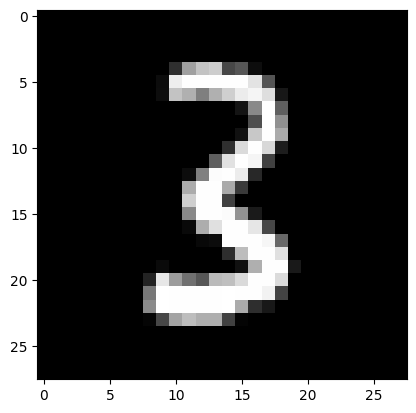

In [75]:
plt.imshow(mini_batch_data[0].view(28,28))
mini_batch_labels[0]

In [76]:
model,opt = get_model()

In [77]:
def fit():
    # Loop through epochs
    for epoch in range(num_epochs):
        # Loop through mini-batches
        for mini_batch_data, mini_batch_labels in train_dataloader:
            # Make predictions using the model
            predictions = model(torch.Tensor(mini_batch_data))

            # Calculate the loss using the loss function
            loss_value = cross_entropy_loss_func(predictions, mini_batch_labels)

            # Backpropagation
            loss_value.backward()

            # Update model parameters using gradient descent
            opt.step()
            opt.zero_grad()

        # Report metrics for the last mini-batch in the epoch
        report_metrics(loss_value.item(), predictions, mini_batch_labels)

In [78]:
fit()
cross_entropy_loss_func(model(mini_batch_data), mini_batch_labels), accuracy(model(mini_batch_data), mini_batch_labels)

Loss: 0.11, Accuracy: 0.98
Loss: 0.09, Accuracy: 0.98
Loss: 0.06, Accuracy: 1.00


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [79]:
import random

In [80]:
class Sampler:
    def __init__(self, dataset, shuffle=False):
        self.num_samples, self.shuffle = len(dataset), shuffle
    
    def __iter__(self):
        sample_indices = list(range(self.num_samples))
        if self.shuffle:
            random.shuffle(sample_indices)
        return iter(sample_indices)

In [81]:
from itertools import islice

In [82]:
ss = Sampler(training_dataset)

In [83]:
it = iter(ss)
for o in range(5):
    print(next(it))

0
1
2
3
4


In [84]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [85]:
ss = Sampler(training_dataset, shuffle=True)
list(islice(ss, 5))

[553, 38875, 43564, 12413, 4468]

In [86]:
import fastcore.all as fc

In [87]:
class BatchSampler:
    def __init__(self, sampler, batch_size, drop_last=False):
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last
    
    def __iter__(self):
        for batch in fc.chunked(iter(self.sampler), self.batch_size, drop_last=self.drop_last):
            yield batch

In [88]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[23681, 86, 31686, 34587],
 [41260, 46576, 41667, 15860],
 [18159, 46216, 45492, 46269],
 [19000, 40491, 36189, 49914],
 [34562, 13726, 16760, 25376]]

In [89]:
def collate(batch):
    inputs, targets = zip(*batch)
    return torch.stack(inputs), torch.stack(targets)

In [90]:
class DataLoader:
    def __init__(self, dataset, batches, collate_fn=collate):
        fc.store_attr()
    
    def __iter__(self):
         yield from (self.collate_fn(self.dataset[i] for i in batch) for batch in self.batches)

In [91]:
train_sampler = BatchSampler(Sampler(training_dataset,   shuffle=True ), batch_size)
valid_sampler = BatchSampler(Sampler(validation_dataset, shuffle=False), batch_size)

In [92]:
train_dataloader = DataLoader(training_dataset, batches=train_sampler)
valid_dataloader = DataLoader(validation_dataset, batches=valid_sampler)

tensor(3)

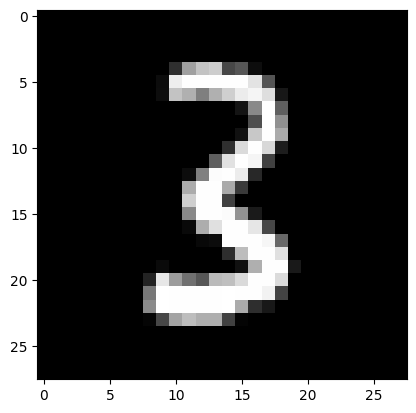

In [93]:
mini_batch_data, mini_batch_labels = next(iter(valid_dataloader))
plt.imshow(mini_batch_data[0].view(28,28))
mini_batch_labels[0]

In [94]:
mini_batch_data.shape, mini_batch_labels.shape

(torch.Size([50, 784]), torch.Size([50]))

In [95]:
model,opt = get_model()

In [96]:
fit()

Loss: 0.40, Accuracy: 0.86
Loss: 0.19, Accuracy: 0.96
Loss: 0.24, Accuracy: 0.96


### Multiprocessing DataLoader

In [97]:
import torch.multiprocessing as mp

In [98]:
training_dataset[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [99]:
training_dataset.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [100]:
for o in map(training_dataset.__getitem__, ([3,6],[8,1])):
    print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [101]:
class DataLoader:
    def __init__(self, dataset, batches, num_workers=1, collate_function=collate):
        fc.store_attr()
    
    def __iter__(self):
        with mp.Pool(self.num_workers) as executor:
            yield from executor.map(self.dataset.__getitem__, iter(self.batches))

In [102]:
train_dataloader = DataLoader(training_dataset, batches=train_sampler, num_workers=8)

In [103]:
it = iter(train_dataloader)

In [104]:
# mini_batch_data, mini_batch_labels = next(it)
# mini_batch_data.shape, mini_batch_labels.shape

### PyTorch DataLoader

In [105]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [111]:
DataLoader?

Init signature:
DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+T_co],
    batch_size: Optional[int] = 1,
    shuffle: Optional[bool] = None,
    sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None,
    batch_sampler: Union[torch.utils.data.sampler.Sampler[Sequence], Iterable[Sequence], NoneType] = None,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[~T]], Any]] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Optional[Callable[[int], NoneType]] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: Optional[int] = None,
    persistent_workers: bool = False,
    pin_memory_device: str = '',
)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, cus

In [106]:
train_sampler = BatchSampler(RandomSampler(training_dataset),       batch_size, drop_last=False)
valid_sampler = BatchSampler(SequentialSampler(validation_dataset), batch_size, drop_last=False)

In [107]:
train_dataloader = DataLoader(training_dataset,   batch_sampler=train_sampler, collate_fn=collate)
valid_dataloader = DataLoader(validation_dataset, batch_sampler=valid_sampler, collate_fn=collate)

In [108]:
model,opt = get_model()
fit()
cross_entropy_loss_func(model(mini_batch_data), mini_batch_labels), accuracy(model(mini_batch_data), mini_batch_labels)

Loss: 0.10, Accuracy: 0.94
Loss: 0.10, Accuracy: 0.96
Loss: 0.27, Accuracy: 0.98


(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(0.98))

PyTorch can auto-generate the BatchSampler for us:

In [109]:
train_dataloader = DataLoader(training_dataset, batch_size, sampler=RandomSampler(training_dataset), collate_fn=collate)
valid_dataloader = DataLoader(validation_dataset, batch_size, sampler=SequentialSampler(validation_dataset), collate_fn=collate)

PyTorch can also generate the Sequential/RandomSamplers too:

In [112]:
train_dataloader = DataLoader(training_dataset, batch_size, shuffle=True, drop_last=True, num_workers=2)
valid_dataloader = DataLoader(validation_dataset, batch_size, shuffle=False, num_workers=2)

In [113]:
model,opt = get_model()
fit()

cross_entropy_loss_func(model(mini_batch_data), mini_batch_labels), accuracy(model(mini_batch_data), mini_batch_labels)

Loss: 0.21, Accuracy: 0.92
Loss: 0.15, Accuracy: 0.94
Loss: 0.04, Accuracy: 0.98


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

Our dataset actually already knows how to sample a batch of indices all at once:

In [114]:
training_dataset[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [115]:
train_dataloader = DataLoader(training_dataset, sampler=train_sampler)
valid_dataloader = DataLoader(validation_dataset, sampler=valid_sampler)

In [116]:
mini_batch_data, mini_batch_labels = next(iter(train_dataloader))
mini_batch_data.shape, mini_batch_labels.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [117]:
#|export
def fit(num_epochs, model, loss_function, optimizer, train_loader, validation_loader):
    """
    Trains a neural network model on a given dataset for a specified number of epochs.
    
    Parameters:
    ----------
    num_epochs : int
        Number of epochs to train the model for.
    model : torch.nn.Module
        Neural network model to be trained.
    loss_function : Callable
        Function that calculates the loss between the model's predictions and the true labels.
    optimizer : torch.optim.Optimizer
        Optimization algorithm to use for updating the model's parameters.
    train_loader : torch.utils.data.DataLoader
        Iterator that loads the training data in mini-batches.
    validation_loader : torch.utils.data.DataLoader
        Iterator that loads the validation data in mini-batches.
    
    Returns:
    -------
    total_loss : float
        Total loss accumulated across all mini-batches in the validation set.
    total_accuracy : float
        Total accuracy accumulated across all mini-batches in the validation set.
    """
    # Loop through epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        
        # Loop through mini-batches in training data
        for batch_data, batch_labels in train_loader:
            # Make predictions using the model
            predictions = model(torch.Tensor(batch_data))
            
            # Calculate the loss using the loss function
            loss_value = loss_function(predictions, batch_labels)
            
            # Perform backpropagation
            loss_value.backward()
            
            # Update model parameters using gradient descent
            optimizer.step()
            optimizer.zero_grad()
        
        # Set the model to evaluation mode
        model.eval()
        
        # Initialize variables to store total loss and accuracy
        total_loss, total_accuracy, batch_count = 0., 0., 0
        
        # Loop through mini-batches in validation data
        for batch_data, batch_labels in validation_loader:
            # Make predictions using the model
            predictions = model(torch.Tensor(batch_data))
            
            # Calculate the loss using the loss function
            loss_value = loss_function(predictions, batch_labels)
            
            # Add the loss and accuracy to the respective totals
            total_loss += loss_value.item() * len(batch_data)
            total_accuracy += accuracy(predictions, batch_labels).item() * len(batch_data)
            
            # Increment the batch count
            batch_count += len(batch_data)
        
        # Print the epoch, total loss, and total accuracy
        print(f"Epoch {epoch + 1}, Total Loss: {total_loss / batch_count}, Total Accuracy: {total_accuracy / batch_count}")
    
    # Return the total loss and accuracy
    return total_loss / batch_count, total_accuracy / batch_count

In [118]:

#|export
def get_dataloaders(training_dataset, validation_dataset, batch_size, **kwargs):
    """
    Creates data loaders for training and validation data.
    
    Parameters:
    -----------
    training_dataset: torch.utils.data.Dataset
        The dataset to use for training.
    validation_dataset: torch.utils.data.Dataset
        The dataset to use for validation.
    batch_size: int
        The batch size to use for both training and validation data loaders.
    **kwargs: dict
        Optional keywords arguments to pass to the DataLoader constructor.
    
    Returns:
    --------
    tuple(DataLoader, DataLoader)
        A tuple containing two data loaders, one for training and one for validation.
    """
    train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size*2, **kwargs)
    return train_dataloader, validation_dataloader

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [119]:
train_dataloader, valid_dataloader = get_dataloaders(training_dataset, validation_dataset, batch_size)
model,opt = get_model()

In [120]:
%time loss,acc = fit(5, model, cross_entropy_loss_func, opt, train_dataloader, valid_dataloader)

Epoch 1, Total Loss: 0.14047490478493274, Total Accuracy: 0.9582000035047531
Epoch 2, Total Loss: 0.12209551422856749, Total Accuracy: 0.9635000067949295
Epoch 3, Total Loss: 0.13450034762732685, Total Accuracy: 0.9630000048875809
Epoch 4, Total Loss: 0.11124097333289683, Total Accuracy: 0.9662000066041947
Epoch 5, Total Loss: 0.11131250839214772, Total Accuracy: 0.9704000061750412
CPU times: user 12.8 s, sys: 63.1 ms, total: 12.9 s
Wall time: 6.44 s


## Export -

In [193]:
# import nbdev; nbdev.nbdev_export()

In [194]:
# !pip install nbdev